In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [ ]:
train_data= pd.read_csv('/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/train_AMD.csv')
test_data=pd.read_csv('/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/test_AMD.csv')

In [ ]:
import numpy as np

def prepare_seq(data,seq_len):    #eg seq=len = 50
    sequences,labels = [],[]
    #len of data is 1353 then 1353 - 50 is the range
    for i in range(len(data) - seq_len):
        #eg 0 to 50
        x_temp = data.iloc[i:i+seq_len].values
        #stores 50th value
        y_temp = data.iloc[i+seq_len].values

        sequences.append(x_temp)
        labels.append(y_temp)

    return np.array(sequences), np.array(labels)

Training of model

In [ ]:
# define the sequence length
SEQ_LENGTH = 50

# process the dataset
train_sequences,train_labels = prepare_seq(train_data, SEQ_LENGTH)
test_sequences,test_labels = prepare_seq(test_data, SEQ_LENGTH)
print(train_sequences.shape, test_sequences.shape)

(957, 50, 4) (202, 50, 4)


creating model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,Dropout
from tensorflow.keras.optimizers import Adam

# define the learning rate and epochs
LR = 0.001
EPOCHS = 50

# build the model
model = Sequential()
model.add(GRU(units=50,return_sequences = True, input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model.add(Dropout(0.1))
model.add(GRU(units = 50))
model.add(Dense(4))

# compile the model
model.compile(optimizer=Adam(learning_rate = LR), loss='mean_squared_error', metrics=['mean_squared_error'])

training model

In [ ]:
# train the model
model.fit(train_sequences,train_labels, epochs=EPOCHS, validation_data = (test_sequences,test_labels),verbose = 'auto')

Epoch 1/50
30/30 [==============================] - 8s 83ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/50
30/30 [==============================] - 1s 47ms/step - loss: 1.5629e-04 - mean_squared_error: 1.5629e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/50
30/30 [==============================] - 1s 50ms/step - loss: 8.1613e-05 - mean_squared_error: 8.1613e-05 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4/50
30/30 [==============================] - 1s 48ms/step - loss: 8.6595e-05 - mean_squared_error: 8.6595e-05 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/50
30/30 [==============================] - 1s 48ms/step - loss: 7.9126e-05 - mean_squared_error: 7.9126e-05 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/50
30/30 [==============================] - 2s 76ms/step - loss: 8.6115e-05 - mean_squared_error: 8.6115e-05 - val_loss: 8.7444e-04 - val_mean_squared_erro

Save best model

In [ ]:
SAVE = True
LSTM_MODEL_PATH = "/content/drive/Shareddrives/1:1_Krishna_Vijay/Results"

# save the model if needed
if SAVE:
    model.save(os.path.join(LSTM_MODEL_PATH, f"best_model_{COMPANY}_GRU.h5"))
    print("Model is saved")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model is saved


Making predictions

In [ ]:
# make predictions
predictions = model.predict(test_sequences)
# inverse tranform the predictions
inverse_predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 1s 13ms/step


making eval function

In [ ]:
# create a dataframe frame using model predictions
PRED_COLUMNS = ['open_predicted','high_predicted','low_predicted','close_predicted']
# create the dataframe
pred_df = pd.concat([df.iloc[-predictions.shape[0]:], pd.DataFrame(inverse_predictions, columns = PRED_COLUMNS, index = df.iloc[-predictions.shape[0]:].index)], axis = 1)
pred_df[COLUMNS] = scaler.inverse_transform(pred_df[COLUMNS])
pred_df.head()

,open,high,low,close,open_predicted,high_predicted,low_predicted,close_predicted
date,,,,,,,,
2017-04-21,100.84,101.79,100.36,101.68,100.216675,101.272133,97.812454,101.271210
2017-04-24,102.96,103.48,102.11,102.95,100.868340,101.957375,98.446724,101.925049
2017-04-25,103.54,105.33,102.67,104.74,101.928223,103.051842,99.518127,103.047165
2017-04-26,105.29,105.39,103.94,104.02,103.193558,104.370850,100.777664,104.350616
2017-04-27,104.32,105.98,103.59,105.64,103.985855,105.125122,101.494263,105.124313


In [ ]:
from sklearn.metrics import mean_squared_error

def evaluations(cols, dataframe = pred_df):
    for column in cols:
        print("{}".format(column))
        pred_col = column.lower() + "_predicted"
        mse = mean_squared_error(dataframe[column].values, dataframe[pred_col].values)
        print("Max and Min: {} and {}".format(dataframe[column].max(), dataframe[column].min()))
        print("MSE:", mse)
        print("RMSE:{}\n".format(np.sqrt(mse)))

        plt.figure(figsize = (10,6))
        plt.plot(dataframe[column], label = "actual")
        plt.plot(dataframe[pred_col], label = "predicted")
        plt.xlabel("Time")
        plt.ylabel(f"Actual and Predicted:{column}")
        plt.title(f"Actual and Predictions Comparison: {column}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()
        print("\n\n")

evaluating

open
Max and Min: 245.77000000000004 and 100.84
MSE: 35.241879430023815
RMSE:5.936487128767636



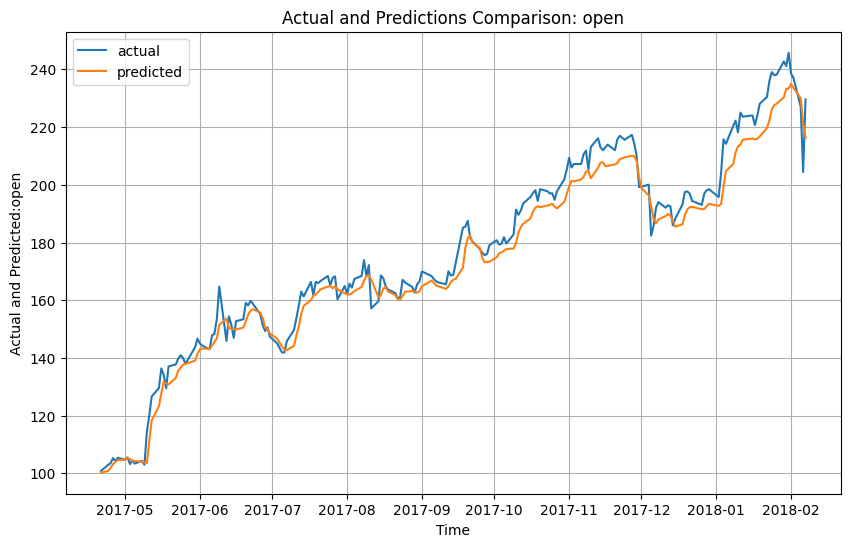




high
Max and Min: 249.27 and 101.79
MSE: 31.558397778129553
RMSE:5.617686158742721



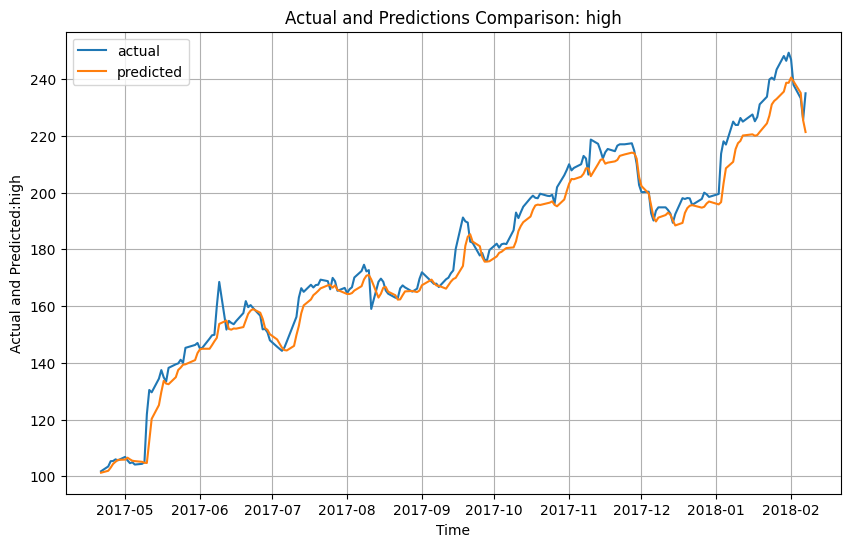




low
Max and Min: 244.45 and 100.36
MSE: 71.82070255344564
RMSE:8.474709585197928



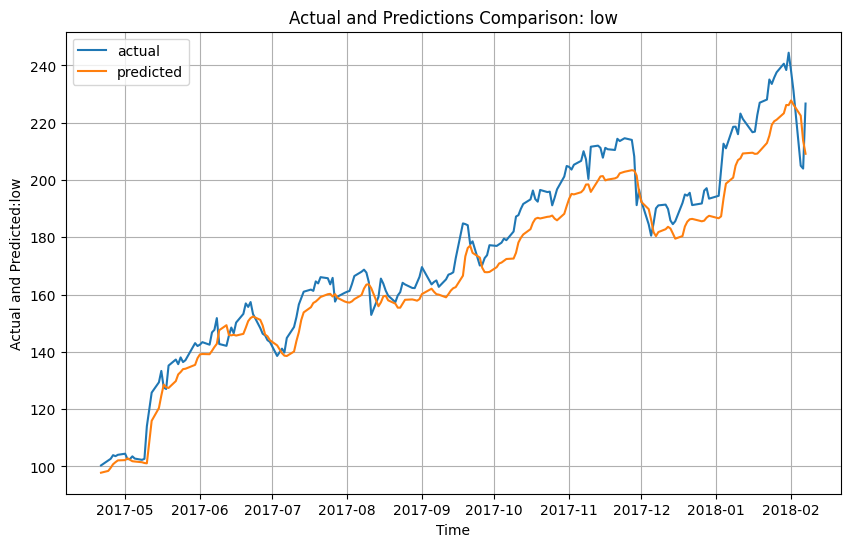




close
Max and Min: 246.84999999999994 and 101.68
MSE: 38.74934595823432
RMSE:6.2248972648738805



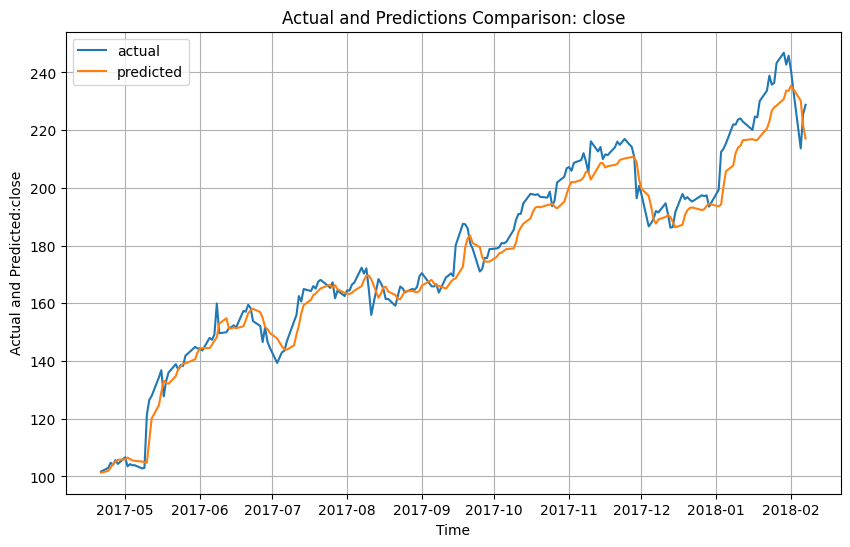

In [ ]:
# make evaluations
evaluations(COLUMNS)